In [ ]:
import gym
import numpy as np
import torch
import torchkit.pytorch_utils as ptu
import torchsde
from torch.nn import functional as F
import random as rnd
import copy as cp
# import environments
import envs.pomdp
import pdb
# import recurrent model-free RL (separate architecture)
from policies.models.policy_rnn import ModelFreeOffPolicy_Separate_RNN as Policy_RNN
from policies.models.policy_rnn_shared import ModelFreeOffPolicy_Shared_RNN as Policy_Shared_RNN
from policies.models.policy_mlp import ModelFreeOffPolicy_MLP as Policy_MLP
from tqdm import tqdm
# import the replay buffer
from buffers.seq_replay_buffer_vanilla import SeqReplayBuffer
from buffers.simple_replay_buffer import SimpleReplayBuffer 
from utils import helpers as utl
from typing import Sequence

## Build a POMDP environment: Pendulum-V (only observe the velocity)

In [ ]:
cuda_id = 0  # -1 if using cpu
ptu.set_gpu_mode(torch.cuda.is_available() and cuda_id >= 0, cuda_id)

env_name = "Pendulum-V-v0"
env = gym.make(env_name)
max_trajectory_len = env._max_episode_steps
act_dim = env.action_space.shape[0]
obs_dim = env.observation_space.shape[0]
#obs_dim =3
print(env, obs_dim, act_dim, max_trajectory_len)
from policies.rl import SAC
algo_name="td3"
algo=SAC(action_dim=act_dim)
print(algo)
print(act_dim)

from policies.rl import RL_ALGORITHMS

observ_embedding_size = 32
action_embedding_size = 8
reward_embedding_size = 8
print(RL_ALGORITHMS)
lr = 0.0003
hidden_size=16


algo = RL_ALGORITHMS[algo_name]( action_dim=act_dim)
encoder = "ncde"
activation = "relu"
shared = False
markov = False

if markov:
    agent = Policy_MLP(
        obs_dim=obs_dim,
        action_dim=act_dim,
        algo_name="td3",
        dqn_layers=[128, 128],
        policy_layers=[128, 128],
        lr=3e-4,
        gamma=0.99,
        tau=5e-3,
    ).to(ptu.device)
    encoder="Nan"
else:
    if shared:
        agent = Policy_Shared_RNN(
            obs_dim=obs_dim,
            action_dim=act_dim,
            encoder=encoder,
            algo_name="td3",
            action_embedding_size=action_embedding_size,
            observ_embedding_size=observ_embedding_size,
            reward_embedding_size=reward_embedding_size,
            rnn_hidden_size=hidden_size,
            dqn_layers=[128, 128],
            policy_layers=[128, 128],
            lr=lr,
            gamma=0.9,
            tau=0.005,
            embed=True,
        ).to(ptu.device)
    else: 
        agent = Policy_RNN(
            obs_dim=obs_dim,
            action_dim=act_dim,
            encoder=encoder,
            algo_name="td3",
            action_embedding_size=action_embedding_size,
            observ_embedding_size=observ_embedding_size,
            reward_embedding_size=reward_embedding_size,
            rnn_hidden_size=hidden_size,
            dqn_layers=[128, 128],
            policy_layers=[128, 128],
            lr=lr,
            gamma=0.9,
            tau=0.005,
            embed=True,
            activation = activation,
        ).to(ptu.device)
    
print(agent)

num_updates_per_iter = 1.0  # training frequency
sampled_seq_len = 64  # context length
buffer_size = 1e6
batch_size = 32
dropout_rate=0.4
num_iters = 500
num_init_rollouts_pool = 20
num_rollouts_per_iter = 5
total_rollouts = num_init_rollouts_pool + num_iters * num_rollouts_per_iter
n_env_steps_total = max_trajectory_len * total_rollouts
_n_env_steps_total = 0
print("total env episodes", total_rollouts, "total env steps", n_env_steps_total)

## Build a recurent model-free RL agent: separate architecture, `lstm` encoder, `oar` policy input space, `td3` RL algorithm (context length set later)

## Define other training parameters such as context length and training frequency

In [34]:
class StochasticLorenzControl(object):
    """Stochastic Lorenz attractor.
    Used for simulating ground truth and obtaining noisy data.
    Details described in Section 7.2 https://arxiv.org/pdf/2001.01328.pdf
    Default a, b from https://openreview.net/pdf?id=HkzRQhR9YX
    """
    noise_type = "diagonal"
    sde_type = "ito"

    def __init__(self, a: Sequence = (1, 1), b: Sequence = (1, 1)):
        super(StochasticLorenzControl, self).__init__()
        self.a = a
        self.b = b

    def f(self, t, y):
        x1, x2, x3 = torch.split(y, split_size_or_sections=(1, 1, 1), dim=1)
        a1, a2 = self.a

        f1 = x1 + x3
        f2 = x1 
        f3 = 0 * x3
        return torch.cat([f1, f2, f3], dim=1)

    def g(self, t, y):
        x1, x2, x3 = torch.split(y, split_size_or_sections=(1, 1, 1), dim=1)
        b1, b2 = self.b

        g1 = 0 * x1 
        g2 = 0 * x2 
        g3 = 0 * x3
        return torch.cat([g1, g2, g3], dim=1)

    @torch.no_grad()
    def sample(self, x0, ts):
        """Sample data for training. Store data normalization constants if necessary."""
        xs = torchsde.sdeint(self, x0, ts)
        #if normalize:
        #    mean, std = torch.mean(xs, dim=(0, 1)), torch.std(xs, dim=(0, 1))
        #    xs.sub_(mean).div_(std).add_(torch.randn_like(xs) * noise_std)
        return xs
    
    
SML = StochasticLorenzControl()

initx= torch.tensor([1.0, 1.0, 0.0])
initx= initx.unsqueeze(0)
ts_exp = torch.linspace(0, 1, 10)
ys= torchsde.sdeint(SML, initx, ts_exp)

ts_exp

tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000])

In [35]:
def step(SML, ys, ts_exp, action):
    

tensor([[[1.0000, 1.0000, 0.0000]],

        [[1.1175, 1.1175, 0.0000]],

        [[1.2488, 1.2488, 0.0000]],

        [[1.3956, 1.3956, 0.0000]],

        [[1.5596, 1.5596, 0.0000]],

        [[1.7429, 1.7429, 0.0000]],

        [[1.9477, 1.9477, 0.0000]],

        [[2.1766, 2.1766, 0.0000]],

        [[2.4324, 2.4324, 0.0000]],

        [[2.7183, 2.7183, 0.0000]]])

## Define key functions: collect rollouts and policy update

In [3]:
def create_ncde_row(obs, next_obs, prev_action, action, prev_reward, reward, steps,init):
    
    if init:
        obs_row= obs
        rew_row = prev_reward
        act_row = prev_action
    else:
        obs_row=torch.cat((obs, next_obs),0)
        rew_row=torch.cat((prev_reward, reward),0)
        act_row=torch.cat((prev_action, action),0)
 
    if shared: 
        obs_row=agent.observ_embedder(obs_row)
        rew_row=agent.reward_embedder(rew_row)
        act_row=agent.action_embedder(act_row)
    else: 
        obs_row=agent.actor.observ_embedder(obs_row)
        rew_row=agent.actor.reward_embedder(rew_row)
        act_row=agent.actor.action_embedder(act_row)
    
    if init:
        time_tensor=torch.tensor([[steps]]).to(ptu.device)
    else:
        time_tensor=torch.tensor([[steps],[steps+1]]).to(ptu.device)

    ncde_row=torch.cat((time_tensor,act_row,obs_row,rew_row),1)
    ncde_row=ncde_row[None,:]
    
    return ncde_row



@torch.no_grad()
def collect_rollouts(
    num_rollouts, random_actions=False, deterministic=True, train_mode=True
):
    """collect num_rollouts of trajectories in task and save into policy buffer
    :param
        random_actions: whether to use policy to sample actions, or randomly sample action space
        deterministic: deterministic action selection?
        train_mode: whether to train (stored to buffer) or test
    """
    if not train_mode:
        assert random_actions == False and deterministic == True

    total_steps = 0
    total_rewards = 0.0
    trewards =[]
    for idx in range(num_rollouts):
        steps = 0
        rewards = 0.0
        energy = 0.0
        print(env.reset())
        obs = ptu.from_numpy(env.reset())
        obs = obs.reshape(1, obs.shape[-1])
        done_rollout = False
        init=True
        # get hidden state at timestep=0, None for mlp
        
        if not markov:
            action, reward, internal_state = agent.get_initial_info()

            if encoder == "ncde":
                internal_state= None
                ncde_row= create_ncde_row(obs, obs, action, action, reward, reward, steps,init)
                prev_action= action.clone()
                prev_reward= reward.clone()
                next_obs= obs.clone()
        
        
        if train_mode:
            # temporary storage
            obs_list, act_list, rew_list, next_obs_list, term_list = (
                [],
                [],
                [],
                [],
                [],
            )
                           

        while not done_rollout:
            if markov: 
                action = agent.act(obs=obs, deterministic=deterministic)[0]
            else:
                if encoder == "ncde":
                    (action,_,_,_), internal_state= agent.ncde_act(ncde_row=ncde_row, prev_internal_state=internal_state, obs=obs,  deterministic=deterministic)
                else:
                    (action, _, _, _), internal_state = agent.act(
                        prev_internal_state=internal_state,
                        prev_action=action,
                        reward=reward,
                        obs=obs,
                        deterministic=deterministic,
                    )
            # observe reward and next obs (B=1, dim)
            #pdb.set_trace()
        
            #print(torch.norm(internal_state))
            next_obs, reward, done, info = utl.env_step(env, action.squeeze(dim=0))
            done_rollout = False if ptu.get_numpy(done[0][0]) == 0.0 else True
            init=False
            
            if not markov:
                if encoder == "ncde":
   
                    ncde_row= create_ncde_row(obs, next_obs, prev_action, action, prev_reward, reward, steps,init)
            
            #switch on/off dropouts
            #drop_trigger=rnd.uniform(0,1)
            #if drop_trigger<dropout_rate:
            #    next_obs=cp.deepcopy(obs)
            # update statistics
           
            rewards += reward.item()
            energy += action*action
           
            # early stopping env: such as rmdp, pomdp, generalize tasks. term ignores timeout
            term = (
                False
                if "TimeLimit.truncated" in info or steps >= max_trajectory_len
                else done_rollout
            )

            if train_mode:
                # append tensors to temporary storage
                obs_list.append(obs)  # (1, dim)
                act_list.append(action)  # (1, dim)
                rew_list.append(reward)  # (1, dim)
                term_list.append(term)  # bool
                next_obs_list.append(next_obs)  # (1, dim)
            steps += 1
            # set: obs <- next_obs
            obs = next_obs.clone()
            prev_reward= reward.clone()
            prev_action= action.clone()
        if train_mode:
            # add collected sequence to buffer
            policy_storage.add_episode(
                observations=ptu.get_numpy(torch.cat(obs_list, dim=0)),  # (L, dim)
                actions=ptu.get_numpy(torch.cat(act_list, dim=0)),  # (L, dim)
                rewards=ptu.get_numpy(torch.cat(rew_list, dim=0)),  # (L, dim)
                terminals=np.array(term_list).reshape(-1, 1),  # (L, 1)
                next_observations=ptu.get_numpy(
                    torch.cat(next_obs_list, dim=0)
                ),  # (L, dim)
            )
        print(
            "Mode:",
            "Train" if train_mode else "Test",
            "env_steps",
            steps,
            "total rewards",
            rewards,
            "total energy",
            energy,
        )
        total_steps += steps
        total_rewards += rewards
        trewards.append(rewards)
    if train_mode:
        return total_steps
    else:
        return total_rewards / num_rollouts, np.std(trewards)


def update(num_updates, factor):
    rl_losses_agg = {}
    # print(num_updates)
    for update in tqdm(range(num_updates), leave=True):
        # sample random RL batch: in transitions
        batch = ptu.np_to_pytorch_batch(policy_storage.random_episodes(batch_size))
        # RL update
        
        rl_losses = agent.update(batch, factor)

        for k, v in rl_losses.items():
            if update == 0:  # first iterate - create list
                rl_losses_agg[k] = [v]
            else:  # append values
                rl_losses_agg[k].append(v)
    # statistics
    for k in rl_losses_agg:
        rl_losses_agg[k] = np.mean(rl_losses_agg[k])
    return rl_losses_agg

## Train and Evaluate the agent: only costs < 20 min

In [4]:
policy_storage = SeqReplayBuffer(
    max_replay_buffer_size=int(buffer_size),
    observation_dim=obs_dim,
    action_dim=act_dim,
    sampled_seq_len=sampled_seq_len,
    sample_weight_baseline=0.0,
)

env_steps = collect_rollouts(
    num_rollouts=num_init_rollouts_pool, random_actions=False, train_mode=True
)
_n_env_steps_total += env_steps

# evaluation parameters
last_eval_num_iters = 10
log_interval = 5
eval_num_rollouts = 10
learning_curve = {
    "x": [],
    "y": [],
    "z": [],
}
epoch=0
lambda_pat = 0.65

while _n_env_steps_total < n_env_steps_total:

    env_steps = collect_rollouts(num_rollouts=num_rollouts_per_iter, train_mode=True)
    _n_env_steps_total += env_steps

    #train_stats = update(int(num_updates_per_iter * env_steps))
    factor= lambda_pat **(epoch )
    #train_stats = update(int(num_updates_per_iter * env_steps))
    train_stats = update(25, lr)
    
    epoch += 1
    current_num_iters = _n_env_steps_total // (
        num_rollouts_per_iter * max_trajectory_len
    )
    if (
        current_num_iters != last_eval_num_iters
        and current_num_iters % log_interval == 0
    ):
        last_eval_num_iters = current_num_iters
        average_returns, std_returns = collect_rollouts(
            num_rollouts=eval_num_rollouts,
            train_mode=False,
            random_actions=False,
            deterministic=True,
        )
        learning_curve["x"].append(_n_env_steps_total)
        learning_curve["y"].append(average_returns)
        learning_curve["z"].append(std_returns)
        print(_n_env_steps_total, average_returns)

buffer RAM usage: 0.02 GB
[-0.3822923]


C:\Users\alexander.vasilyev\Anaconda3\lib\site-packages\torch\nn\functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Mode: Train env_steps 200 total rewards -1172.6249842643738 total energy tensor([[0.0010]])
[0.30297345]
Mode: Train env_steps 200 total rewards -1236.4324131011963 total energy tensor([[0.0010]])
[-0.00518003]
Mode: Train env_steps 200 total rewards -1435.6666464805603 total energy tensor([[0.0008]])
[-0.11477902]
Mode: Train env_steps 200 total rewards -1633.7348494529724 total energy tensor([[0.0006]])
[0.32809815]
Mode: Train env_steps 200 total rewards -1568.1449666023254 total energy tensor([[0.0006]])
[0.60433555]
Mode: Train env_steps 200 total rewards -1645.769688129425 total energy tensor([[0.0006]])
[0.84826]
Mode: Train env_steps 200 total rewards -1660.3081645965576 total energy tensor([[0.0006]])
[0.6859137]
Mode: Train env_steps 200 total rewards -627.7105251159519 total energy tensor([[0.0010]])
[-0.5691567]
Mode: Train env_steps 200 total rewards -1452.7149124145508 total energy tensor([[0.0008]])
[-0.08591741]
Mode: Train env_steps 200 total rewards -1909.221320152282

  0%|          | 0/25 [00:00<?, ?it/s]C:\Users\alexander.vasilyev\pomdp-baselines-main\torchkit\pytorch_utils.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if v.dtype == np.bool:


tensor(0.1610)


  4%|▍         | 1/25 [00:00<00:16,  1.47it/s]

tensor(0.1574)


  8%|▊         | 2/25 [00:01<00:14,  1.54it/s]

tensor(0.1649)


 12%|█▏        | 3/25 [00:01<00:14,  1.53it/s]

tensor(0.1511)


 16%|█▌        | 4/25 [00:02<00:13,  1.53it/s]

tensor(0.1540)


 20%|██        | 5/25 [00:03<00:12,  1.56it/s]

tensor(0.1610)


 24%|██▍       | 6/25 [00:03<00:11,  1.63it/s]

tensor(0.1592)


 28%|██▊       | 7/25 [00:04<00:10,  1.66it/s]

tensor(0.1581)


 32%|███▏      | 8/25 [00:04<00:10,  1.69it/s]

tensor(0.1609)


 36%|███▌      | 9/25 [00:05<00:09,  1.68it/s]

tensor(0.1596)


 40%|████      | 10/25 [00:06<00:08,  1.70it/s]

tensor(0.1588)


 44%|████▍     | 11/25 [00:06<00:08,  1.69it/s]

tensor(0.1617)


 48%|████▊     | 12/25 [00:07<00:07,  1.70it/s]

tensor(0.1593)


 52%|█████▏    | 13/25 [00:07<00:06,  1.72it/s]

tensor(0.1534)


 56%|█████▌    | 14/25 [00:08<00:06,  1.60it/s]

tensor(0.1597)


KeyboardInterrupt: 

## Draw the learning curve

{'x': [5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000, 55000, 60000, 65000, 70000, 75000, 80000, 85000, 90000, 95000, 100000, 105000, 110000, 115000, 120000, 125000, 130000, 135000, 140000, 145000, 150000, 155000, 160000, 165000, 170000, 175000, 180000, 185000, 190000, 195000, 200000, 205000, 210000, 215000, 220000, 225000, 230000, 235000, 240000, 245000, 250000, 255000, 260000, 265000, 270000, 275000, 280000, 285000, 290000, 295000, 300000, 305000, 310000, 315000, 320000, 325000, 330000, 335000, 340000, 345000, 350000, 355000, 360000, 365000, 370000, 375000, 380000, 385000, 390000, 395000, 400000, 405000, 410000, 415000, 420000, 425000, 430000, 435000, 440000, 445000, 450000, 455000, 460000, 465000, 470000, 475000, 480000, 485000, 490000, 495000, 500000], 'y': [-1433.7184145445003, -1382.3333532452584, -1286.414794684481, -1472.3010561138392, -1571.3373125955463, -1427.4685675591231, -1535.2300764482468, -1522.019691227749, -1456.404469114542, -1520.6789950549603,

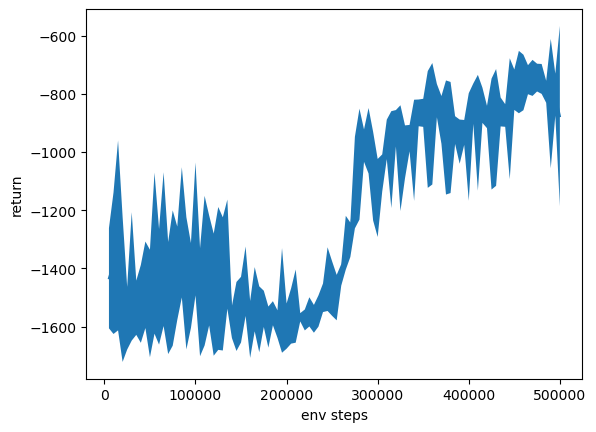

In [5]:
import matplotlib.pyplot as plt
print(learning_curve)
plt.plot(learning_curve["x"], learning_curve["y"])
plt.fill_between(np.array(learning_curve["x"]), np.array(learning_curve["y"])-np.array(learning_curve["z"]), np.array(learning_curve["y"])+np.array(learning_curve["z"]))
plt.xlabel("env steps")
plt.ylabel("return")
plt.show()

In [9]:
print(gym.__version__)

0.23.1


In [9]:
learning_curve_ncde= learning_curve


In [14]:
timess=torch.linspace(0, 65-1, 65)

In [10]:
learning_curve


{'x': [], 'y': []}

In [6]:
rnn = torch.nn.LSTM(10, 20, 2)
input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
c0 = torch.randn(2, 3, 20)
output, (hn, cn) = rnn(input, (h0, c0))

In [7]:
output.size()



torch.Size([5, 3, 20])

In [5]:
def projection (x, y):
    
    proj= y*torch.sum(x*y)/(torch.norm(y)**2)
    
    return proj


In [11]:
x = torch.tensor([1.0,1.0])
y = torch.tensor([1.0,-1.0])

In [12]:
proj = projection(x,y)


In [13]:
proj

tensor([0., -0.])